# cx2313_ly2637 Final Project

### Setup

In [221]:
import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
from shapely import wkt
from shapely.geometry import Point
import sqlalchemy as db

from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, Float, String, DateTime, create_engine
from sqlalchemy.ext.declarative import declarative_base

In [3]:
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "4P7xr8685SCdZVFOLXScTCqJi"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

### Part 1: Data Preprocessing

The first part of the project involves two main activities. The initial step is to download specific datasets manually. This is followed by using Python scripts for automated data downloads. Once the data is collected, the next step is to sort through it. This includes selecting the relevant information, fixing any missing or incorrect data, and creating samples from these datasets for further analysis.

#### 1.1 Load and clean data for zipcode file
- For the zipcode file, first, we'll remove any columns that are not needed. Next, we'll review the basic information of the dataset. Following that, we'll identify the parts that need cleaning and proceed with the cleaning process.

In [125]:
# Step 1: Load data and remove unnecessary columns
zipcode_data_file = DATA_DIR / "nyc_zipcodes.shp"
gdf = gpd.read_file(zipcode_data_file)

columns_to_keep = ['ZIPCODE', 'STATE', 'COUNTY', 'geometry']
zipcode_gdf = gdf[columns_to_keep]

# Rename columns for consistency
zipcode_gdf = zipcode_gdf.rename(columns={'ZIPCODE': 'zipcode', 'City': 'city','COUNTY': 'county','STATE': 'state'})

In [126]:
# Step 2: basic information of the data.
print(zipcode_gdf.info())
zipcode_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   263 non-null    object  
 1   state     263 non-null    object  
 2   county    263 non-null    object  
 3   geometry  263 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 8.3+ KB
None


,zipcode,state,county,geometry
0,11436,NY,Queens,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,NY,Kings,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,NY,Kings,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,NY,Kings,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,NY,Kings,"POLYGON ((991997.113 176307.496, 992042.798 17..."


- From the results we observed, it's clear that the geometry column in the zipcode file is not in the WGS coordinate system. Therefore, we will need to include a transformation in our clean function to convert the geometries to the WGS system for consistency and analysis compatibility.

- Furthermore, we will drop any duplicate rows to ensure data integrity and accuracy for our analysis and reporting. This step is crucial for maintaining the quality of our dataset and providing reliable insights.

    - In our dataset, each zipcode is intended to correspond to a unique set of boundary data, representing a specific geographic area. This one-to-one relationship between a zipcode and its boundaries is crucial for the integrity and accuracy of our geographical analyses. Therefore, we have opted for a data cleaning approach that involves removing duplicate entries based solely on the `zipcode` column.

In [127]:
# Step 3: Clean function
def clean_zipcode_data(gdf):
    gdf_cleaned = gdf.copy()
    
    # Change to WGS system for consistency
    gdf_cleaned = gdf_cleaned.to_crs(epsg=4326)
    
    # Validate geometric data in 'geometry'
    gdf_cleaned = gdf_cleaned[gdf_cleaned['geometry'].is_valid]

    # Remove rows with any missing values
    gdf_cleaned = gdf_cleaned.dropna()
    
    # Remove duplicates
    gdf_cleaned = gdf_cleaned.drop_duplicates(subset='zipcode')

    # Check that all zipcodes are 5 characters long
    gdf_cleaned = gdf_cleaned[gdf_cleaned['zipcode'].apply(lambda x: len(str(x)) == 5)]

    # Ensure categorical consistency
    categorical_columns = ['state', 'county']
    for col in categorical_columns:
        gdf_cleaned.loc[:, col] = gdf_cleaned[col].str.title()
    
    return gdf_cleaned

cleaned_zipcode_gdf = clean_zipcode_data(zipcode_gdf)

- Check cleaned data in details

In [128]:
print(cleaned_zipcode_gdf.info())
cleaned_zipcode_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 248 entries, 0 to 262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   state     248 non-null    object  
 2   county    248 non-null    object  
 3   geometry  248 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 9.7+ KB
None


,zipcode,state,county,geometry
0,11436,Ny,Queens,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,Ny,Kings,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,Ny,Kings,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,Ny,Kings,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,Ny,Kings,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


Now that we have all the zipcode information for New York City, we need to extract this information to use as a reference. This will help us filter the data needed for `311`, `tree`, and `Zillow`. We will include this step in the cleaning steps for `tree`, `311`, and `Zillow` files.

#### 1.2 Download and clean data for trees 
- For the download part, due to the large volume of data, a script is implemented to download, process, and store New York City tree data in a GeoJSON file, handling the data in chunks to manage the size and complexity efficiently. 

In [ ]:
def download_nyc_geojson_data(url_base, filename, force=False):
    limit = 50000  
    offset = 0  
    all_data = []

    if force or not filename.exists():
        print(f"Downloading data to {filename}...")

        try:
            while True:
                params = {
                    '$limit': limit,
                    '$offset': offset,
                    '$$app_token': "4P7xr8685SCdZVFOLXScTCqJi"
                }
                url_with_params = f"{url_base}?{urllib.parse.urlencode(params)}"
                print("Requesting URL:", url_with_params)
                response = requests.get(url_with_params)
                response.raise_for_status()

                data = response.json()
                if not data['features']: 
                    break

                all_data.extend(data['features'])
                offset += limit
            
            geojson_feature_collection = {
                "type": "FeatureCollection",
                "features": all_data
            }

            with open(filename, "w") as f:
                json.dump(geojson_feature_collection, f)

            print(f"Done downloading data to {filename}.")
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    else:
        print(f"Reading from {filename}...")

    return filename

nyc_tree_data_file = DATA_DIR / "nyc_tree_data.geojson"
download_nyc_geojson_data("https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson", nyc_tree_data_file)

- Next, we will use GeoPandas to read the GeoJSON file, and then examine the data for any inconsistencies or areas that may require cleaning.
- Upon understanding the issues that require analysis, we will also select the necessary columns in this step, The columns we will use are `tree_id`, `zipcode`, `latitude`, `longitude`, `status`, `health`, `spc_common`, and `geometry`.

In summary, regarding the tree data, our approach will be as follows: First, we will remove unnecessary columns. Second, we will examine the basic information of the data. Third, we will clean the data where necessary. Since we are using GeoPandas to read the GeoJSON data, the dataframe will include a column named 'geometry', which is already in the WGS coordinate system, so no further processing is required for this column.

In [33]:
# Step 1: Load data and remove unnecessary columns.
nyc_tree_data_file = DATA_DIR / "nyc_tree_data.geojson"

geodf_tree_data=gpd.read_file(nyc_tree_data_file)
columns_to_keep = ['tree_id', 'zipcode', 'latitude', 'longitude', 'status', 'health', 'spc_common', 'geometry']
tree_gdf = geodf_tree_data[columns_to_keep]

In [84]:
# Step 2: basic information of the data.
print(tree_gdf.info())
tree_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   tree_id     683788 non-null  object  
 1   zipcode     683788 non-null  object  
 2   latitude    683788 non-null  object  
 3   longitude   683788 non-null  object  
 4   status      683788 non-null  object  
 5   health      652172 non-null  object  
 6   spc_common  652169 non-null  object  
 7   geometry    683788 non-null  geometry
dtypes: geometry(1), object(7)
memory usage: 41.7+ MB
None


,tree_id,zipcode,latitude,longitude,status,health,spc_common,geometry
0,180683,11375,40.72309177,-73.84421522,Alive,Fair,red maple,POINT (-73.84422 40.72309)
1,200540,11357,40.79411067,-73.81867946,Alive,Fair,pin oak,POINT (-73.81868 40.79411)
2,204026,11211,40.71758074,-73.9366077,Alive,Good,honeylocust,POINT (-73.93661 40.71758)
3,204337,11211,40.71353749,-73.93445616,Alive,Good,honeylocust,POINT (-73.93446 40.71354)
4,189565,11215,40.66677776,-73.97597938,Alive,Good,American linden,POINT (-73.97598 40.66678)


In [6]:
tree_with_nan = tree_gdf[tree_gdf.isnull().any(axis=1)]
num_rows_with_nan = len(tree_with_nan)
total_rows = len(tree_gdf)
percent_with_nan = (num_rows_with_nan / total_rows) * 100

print(f"percentage with nan: {percent_with_nan:.2f}%")
print(f"Number of duplicates: {tree_gdf.duplicated().sum()}")

percentage with nan: 4.62%
Number of duplicates: 0


The output indicates that the GeoDataFrame contains 683,788 entries across 7 columns. Of these, only the `health` and 
`spc_common` columns have missing values, as all other columns have a non-null count of 683,788. 

Given that the `health` and `spc_common` columns cannot be effectively imputed, and after assessing that missing values account for only 4.62% of the total data, the decision to delete all rows with missing values is deemed reasonable. 

Due to the diverse nature of our tree datasets, it containing unique and valuable information, we have opted to remove duplicates only when an entire row is identical. This approach ensures the preservation of all distinct data points, crucial for our comprehensive analysis.

- For example, a single tree_id might have several records that document various states of the same tree over time.

In [145]:
# Step 3: Clean function
def clean_tree_data(gdf):
    gdf_cleaned = gdf.copy()
    
    # Filter based on zip codes present in the 'zipcode' dataframe
    gdf_cleaned = gdf_cleaned[gdf_cleaned['zipcode'].isin(cleaned_zipcode_gdf['zipcode'])]
    
    # Convert 'latitude' and 'longitude' to float
    gdf_cleaned['latitude'] = pd.to_numeric(gdf_cleaned['latitude'], errors='coerce')
    gdf_cleaned['longitude'] = pd.to_numeric(gdf_cleaned['longitude'], errors='coerce')
    
    # Ensure categorical consistency
    categorical_columns = ['status', 'health', 'spc_common']
    for col in categorical_columns:
        gdf_cleaned.loc[:, col] = gdf_cleaned[col].str.title() 
    
    # Validate geometric data in 'geometry'
    gdf_cleaned = gdf_cleaned[gdf_cleaned['geometry'].is_valid]
    
    # Remove duplicates
    gdf_cleaned = gdf_cleaned.drop_duplicates()
    
    # Remove rows with missing values
    gdf_cleaned = gdf_cleaned.dropna()
    
    return gdf_cleaned

cleaned_tree_gdf = clean_tree_data(tree_gdf)

- Check clean data for details

In [146]:
print(cleaned_tree_gdf.info())
cleaned_tree_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 652167 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   tree_id     652167 non-null  object  
 1   zipcode     652167 non-null  object  
 2   latitude    652167 non-null  float64 
 3   longitude   652167 non-null  float64 
 4   status      652167 non-null  object  
 5   health      652167 non-null  object  
 6   spc_common  652167 non-null  object  
 7   geometry    652167 non-null  geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 44.8+ MB
None


,tree_id,zipcode,latitude,longitude,status,health,spc_common,geometry
0,180683,11375,40.723092,-73.844215,Alive,Fair,Red Maple,POINT (-73.84422 40.72309)
1,200540,11357,40.794111,-73.818679,Alive,Fair,Pin Oak,POINT (-73.81868 40.79411)
2,204026,11211,40.717581,-73.936608,Alive,Good,Honeylocust,POINT (-73.93661 40.71758)
3,204337,11211,40.713537,-73.934456,Alive,Good,Honeylocust,POINT (-73.93446 40.71354)
4,189565,11215,40.666778,-73.975979,Alive,Good,American Linden,POINT (-73.97598 40.66678)


#### 1.3 Download and clean data for 311 complaints
- Regarding the 311 data, given its immense volume, we opted to filter the data during the downloading phase, after understanding the requirements for subsequent analysis. Initially, we filtered the data by date, selecting records between January 1, 2015, at 00:00:00 and September 30, 2023, at 23:59:59. Subsequently, we chose to download only the following columns: `latitude, longitude, incident_zip, created_date, location, complaint_type`.

In [ ]:
def download_nyc311_geojson_data(url_base, filename, force=False):
    start_date = '2015-01-01T00:00:00'
    end_date = '2023-09-30T23:59:59'
    limit = 2500000  
    offset = 0 
    all_data = []

    if force or not filename.exists():
        print(f"Downloading data to {filename}...")

        try:
            while True:
                params = {
                    '$where': f"created_date between '{start_date}' and '{end_date}'",
                    '$limit': limit,
                    '$offset': offset,
                    '$$app_token': "4P7xr8685SCdZVFOLXScTCqJi",
                    '$select': 'latitude,longitude,incident_zip,created_date,location,complaint_type'  
                }
                url_with_params = f"{url_base}?{urllib.parse.urlencode(params)}"
                print("Requesting URL:", url_with_params)
                response = requests.get(url_with_params)
                response.raise_for_status()

                data = response.json()
                if not data['features']: 
                    break

                all_data.extend(data['features'])  
                offset += limit

            geojson_feature_collection = {
                "type": "FeatureCollection",
                "features": all_data
            }

            with open(filename, "w") as f:
                json.dump(geojson_feature_collection, f)

            print(f"Done downloading data to {filename}.")
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    else:
        print(f"Reading from {filename}...")

    return filename

nyc_311_data_file = DATA_DIR / "nyc_311_data.geojson"
download_nyc311_geojson_data("https://data.cityofnewyork.us/resource/erm2-nwe9.geojson", nyc_311_data_file)

- Next, we will follow the same steps as we did when cleaning the tree data. First, we need to review the basic information of the data. Second, we need to identify which parts of the data require cleaning, and then write a clean function to address these issues.

In [9]:
# Step 1: Load data
nyc_311_data_file = DATA_DIR / "nyc_311_data.geojson"

nyc311_gdf=gpd.read_file(nyc_311_data_file)

In [150]:
# Step 2: basic information of the data.
print(nyc311_gdf.info())
nyc311_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24336507 entries, 0 to 24336506
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   incident_zip    object        
 4   complaint_type  object        
 5   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(4)
memory usage: 1.1+ GB
None


,latitude,created_date,longitude,incident_zip,complaint_type,geometry
0,40.655672001198894,2023-09-30 23:59:58,-73.95917686020623,11226,Noise - Street/Sidewalk,POINT (-73.95918 40.65567)
1,40.76675595839554,2023-09-30 23:59:38,-73.78751847563191,11361,Noise - Residential,POINT (-73.78752 40.76676)
2,40.71949965458691,2023-09-30 23:59:35,-73.98486650733275,10002,Noise - Commercial,POINT (-73.98487 40.71950)
3,40.687499303408536,2023-09-30 23:59:34,-73.7972903094197,11435,Noise - Residential,POINT (-73.79729 40.68750)
4,40.65220215349917,2023-09-30 23:59:28,-73.9579464603267,11226,Noise - Residential,POINT (-73.95795 40.65220)


In [12]:
nyc311_with_nan = nyc311_gdf[nyc311_gdf.isnull().any(axis=1)]
num_rows_with_nan = len(nyc311_with_nan)
total_rows = len(nyc311_gdf)
percent_with_nan = (num_rows_with_nan / total_rows) * 100

print(f"percentage with nan: {percent_with_nan:.2f}%")
print(f"Number of duplicates: {nyc311_gdf.duplicated().sum()}")

percentage with nan: 5.37%
Number of duplicates: 907072


In [ ]:
# Print columns with missing values
columns_with_missing_values = nyc311_gdf.columns[nyc311_gdf.isnull().any()].tolist()
print(columns_with_missing_values)

['latitude', 'longitude', 'incident_zip', 'geometry']


The output indicates that the GeoDataFrame contains 24336507 entries across 6 columns. Of these, `latitude`, `longtitude` and 
`incident_zip` columns have missing values.

Additionally, we can observe that there are a total of 907072 identical rows. These will be removed in the subsequent cleaning steps.

- When two rows in the dataset are completely identical across all their fields, it typically indicates a case of duplication. Such duplicates don't add any additional value or information. In fact, they can skew analysis and results if not addressed. Therefore, in the upcoming data cleaning steps, one of each pair of identical rows will be removed. 

Given that the `latitude`, `longtitude` and `incident_zip` columns cannot be effectively imputed, and after assessing that missing values account for only 5.37% of the total data, the decision to delete all rows with missing values is deemed reasonable.

In [ ]:
# Step 3: Clean function
def clean_311_data(gdf):
    gdf_cleaned = gdf.copy()
    
    # Rename 'incident_zip' to 'zipcode' for consistant in later mapping
    gdf_cleaned.rename(columns={'incident_zip': 'zipcode'}, inplace=True)
    
    # Filter based on zip codes present in the 'zipcode' dataframe
    gdf_cleaned = gdf_cleaned[gdf_cleaned['zipcode'].isin(cleaned_zipcode_gdf['zipcode'])]
    
    # Convert 'latitude' and 'longitude' to float
    gdf_cleaned['latitude'] = pd.to_numeric(gdf_cleaned['latitude'], errors='coerce')
    gdf_cleaned['longitude'] = pd.to_numeric(gdf_cleaned['longitude'], errors='coerce')
    
    # Validate geometric data in 'geometry'
    gdf_cleaned = gdf_cleaned[gdf_cleaned['geometry'].is_valid]
    
    # Remove duplicates
    gdf_cleaned = gdf_cleaned.drop_duplicates()
    
    # Remove rows with missing values
    gdf_cleaned = gdf_cleaned.dropna(subset=['latitude', 'longitude', 'zipcode'])
    
    return gdf_cleaned

cleaned_311_gdf = clean_311_data(nyc311_gdf)

In [151]:
print(cleaned_311_gdf.info())
cleaned_311_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22233352 entries, 0 to 24336505
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        float64       
 1   created_date    datetime64[ns]
 2   longitude       float64       
 3   zipcode         object        
 4   complaint_type  object        
 5   geometry        object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 1.2+ GB
None


,latitude,created_date,longitude,zipcode,complaint_type,geometry
0,40.655672,2023-09-30 23:59:58,-73.959177,11226,Noise - Street/Sidewalk,POINT (-73.95917686020623 40.655672001198894)
1,40.766756,2023-09-30 23:59:38,-73.787518,11361,Noise - Residential,POINT (-73.78751847563191 40.76675595839554)
2,40.719500,2023-09-30 23:59:35,-73.984867,10002,Noise - Commercial,POINT (-73.98486650733275 40.71949965458691)
3,40.687499,2023-09-30 23:59:34,-73.797290,11435,Noise - Residential,POINT (-73.7972903094197 40.687499303408536)
4,40.652202,2023-09-30 23:59:28,-73.957946,11226,Noise - Residential,POINT (-73.9579464603267 40.65220215349917)


#### 1.4 Load and clean data for Historical monthly average rents by zip code from Zillow
- For the Zillow data, since our entire project is focused on New York City, we will first need to filter for data pertaining to NYC. Then, based on our understanding of the requirements for subsequent analysis, we will retain the columns that are useful.

- According to the subsequent analysis requirements, we only need to reserve the rental prices of 2023-08-31, 2023-01-31 and 2023-09-31.

In [130]:
# Step 1: Load data and remove unnecessary columns
zillow_data_file = DATA_DIR / "zillow_rent_data.csv"
df = pd.read_csv(zillow_data_file)

columns_to_keep = ['2023-08-31','2023-01-31','2023-09-30','RegionName','City','CountyName']
zillow_df = df[columns_to_keep]

# Rename columns for consistency
zillow_df = zillow_df.rename(columns={'RegionName': 'zipcode','City': 'city','CountyName': 'county'})
zillow_df = zillow_df.rename(columns = {'2023-08-31':'date_2023_08_31','2023-01-31':'date_2023_01_31','2023-09-30':'date_2023_09_30'})

In [131]:
# Step 2: basic information of the data.
print(zillow_df.info())
zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_2023_08_31  6251 non-null   float64
 1   date_2023_01_31  4816 non-null   float64
 2   date_2023_09_30  6722 non-null   float64
 3   zipcode          6722 non-null   int64  
 4   city             6665 non-null   object 
 5   county           6722 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 315.2+ KB
None


,date_2023_08_31,date_2023_01_31,date_2023_09_30,zipcode,city,county
0,2053.486247,2027.438438,2055.771355,77494,Katy,Fort Bend County
1,1795.384582,1738.217986,1799.631140,77449,Katy,Harris County
2,1757.602011,1706.900064,1755.031490,77084,Houston,Harris County
3,1488.180414,1458.063897,1494.366097,79936,El Paso,El Paso County
4,3064.476503,2895.699421,3079.585783,11385,New York,Queens County


- From the output above, We see many missing rent prices in the data, so we need to fill these in. This will help us get a full and accurate picture of rent changes over time.

- We decided to estimate the missing monthly rents by carrying forward the last recorded price and then using the following known price when necessary. This makes sense because rent doesn't usually change too much from month to month. If we have a missing price, it's a safe bet that it was close to what it was the month before, or it will be similar to the price after. That's why we use these filling methods; they're like educated guesses that keep things simple and sensible.

In [132]:
# Step 3: Clean function 
def clean_zillow_data(df):
    # Convert 'zipcode' to an object for consistency with other datasets
    df['zipcode'] = df['zipcode'].astype(str)
    
    # Filter based on zip codes present in the 'zipcode' dataframe
    df = df[df['zipcode'].isin(cleaned_zipcode_gdf['zipcode'])]
    
    # Fill missing data row-wise using forward-fill and then backward-fill
    df = df.fillna(method='ffill', axis=0)
    df = df.fillna(method='bfill', axis=0)

    # Remove duplicates
    df = df.drop_duplicates()
    
    # Ensure categorical consistency
    categorical_columns = ['city', 'county']
    for col in categorical_columns:
        df.loc[:, col] = df[col].str.title() 
    
    return df

cleaned_zillow_df = clean_zillow_data(zillow_df)

In [133]:
print(cleaned_zillow_df.info())
cleaned_zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 4 to 6721
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_2023_08_31  146 non-null    float64
 1   date_2023_01_31  146 non-null    float64
 2   date_2023_09_30  146 non-null    float64
 3   zipcode          146 non-null    object 
 4   city             146 non-null    object 
 5   county           146 non-null    object 
dtypes: float64(3), object(3)
memory usage: 8.0+ KB
None


,date_2023_08_31,date_2023_01_31,date_2023_09_30,zipcode,city,county
4,3064.476503,2895.699421,3079.585783,11385,New York,Queens County
6,2737.547470,2588.030194,2728.733333,11208,New York,Kings County
12,2285.460026,2588.030194,2362.500000,11236,New York,Kings County
13,2353.686402,2155.617718,2423.888889,10467,New York,Bronx County
14,2302.557354,2255.604528,2292.994444,11373,New York,Queens County


**Now, we have four cleaned data:**
- cleaned_tree_gdf
- cleaned_311_gdf
- cleaned_zillow_df
- cleaned_zipcode_gdf

### Part 2: Storing Data

- First step we have to create the data base and postgis extension

In [46]:
! /Applications/Postgres.app/Contents/Versions/latest/bin/createdb 'FinalProject'
! /Applications/Postgres.app/Contents/Versions/latest/bin/psql --dbname 'FinalProject' -c 'CREATE EXTENSION postgis;'

createdb: error: database creation failed: ERROR:  database "FinalProject" already exists
ERROR:  extension "postgis" already exists


- In this part, we've set up a database using SQLAlchemy and PostgreSQL to manage data related to trees, 311 service requests, zipcode and Zillow. We first created classes. After defining these classes, We generated the corresponding tables in the database. We also created a function for data convertion which is from dataframe to sql. Finally, we saved the SQL schema to a file named `schema.sql` for future reference. 

In [121]:
from sqlalchemy import create_engine, Column, Integer, Float, String, Text, DateTime, MetaData
from sqlalchemy.ext.declarative import declarative_base
from geoalchemy2 import Geometry
from sqlalchemy.schema import CreateTable

engine = create_engine('postgresql://xcq:x@localhost/FinalProject')
Base = declarative_base()

class Three_11(Base):
    __tablename__ = "three_11s"
    id = Column(Integer, primary_key=True)
    zipcode = Column(Integer)
    latitude = Column(Float)
    longitude = Column(Float)
    created_date = Column(DateTime)
    geometry = Column(Geometry('POINT'))  
    complaint_type = Column(String)
    
class Tree(Base):
    __tablename__ = "trees"
    id = Column(Integer, primary_key=True)
    tree_id = Column(String)
    zipcode = Column(Integer)
    latitude = Column(Float)
    longitude = Column(Float)
    status = Column(String)
    health = Column(String)
    spc_common = Column(String)
    geometry = Column(Geometry('POINT')) 
    
class Zipcode(Base):
    __tablename__ = "zipcodes"
    id = Column(Integer, primary_key=True)
    zipcode = Column(Integer)
    area = Column(String)
    state = Column(String)
    county = Column(String)
    geometry = Column(Geometry('POLYGON')) 


class Zillow(Base):
    __tablename__ = "zillows"
    id = Column(Integer, primary_key=True)
    zipcode = Column(Integer)
    city = Column(String)
    county = Column(String)
    date_2023_08_31 = Column(Float) 
    date_2023_01_31 = Column(Float)
    date_2023_09_30 = Column(Float)
    
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

In [122]:
metadata = MetaData(bind=engine)
metadata.reflect()

with open('schema.sql', 'w') as f:
    for table in Base.metadata.tables.values():
        f.write(str(CreateTable(table)))
        f.write("\n\n")

In [234]:
def write_geodataframe_to_sql(gdf, table_name, engine, if_exists='replace', index=False):
    """
    Writes a GeoDataFrame to a PostgreSQL database table.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to be written to the database.
    table_name (str): Name of the target database table.
    engine: SQLAlchemy database engine.
    """

    # Convert geometry to WKT format.
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)
    gdf.to_sql(table_name, engine, if_exists=if_exists, index=index)


def write_dataframe_to_sql(df, table_name, engine, if_exists='replace', index=False):
    """
    Writes a DataFrame to a PostgreSQL database table.

    Parameters:
    df (DataFrame): The DataFrame to be written to the database.
    table_name (str): Name of the target database table.
    engine: SQLAlchemy database engine.
    """

    df.to_sql(table_name, engine, if_exists=if_exists, index=index)

In [147]:
write_geodataframe_to_sql(cleaned_tree_gdf, 'trees', engine)

/var/folders/3g/vwgvzrmn3kb9gnqyl0268qfh0000gn/T/ipykernel_31889/3339454612.py:12: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)


In [157]:
write_geodataframe_to_sql(cleaned_311_gdf, 'three_11s', engine)

In [129]:
write_geodataframe_to_sql(cleaned_zipcode_gdf, 'zipcodes', engine)

/var/folders/3g/vwgvzrmn3kb9gnqyl0268qfh0000gn/T/ipykernel_31889/3339454612.py:12: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt if geom is not None else None)


In [134]:
write_dataframe_to_sql(cleaned_zillow_df,'zillows',engine)

### Part 3: Understanding Data

- In Part 3, We will be crafting a set of SQL queries to develop a better understanding of the datasets we are working with.

In [159]:
def write_query_to_file(query, outfile):
    """
    Writes a given SQL query to a sql file.
    Args:
        query: The SQL query string.
        outfile: The file path where the query will be written.
    """
    with open(outfile, 'w') as file:
        file.write(query)

##### Query 1: Which area might be more calm to live in?

- The following output shows the number of 311 complaints per zip code between October 1st, 2022 and September 30th, 2023 (inclusive).

In [160]:
QUERY_1_FILENAME = QUERY_DIR / "calm_to_live_in_area.sql"

QUERY_1 = """
SELECT "zipcode" AS "Incident Zip", COUNT(*) AS num_complaints
FROM three_11s
WHERE "created_date" >= '2022-10-01' AND "created_date" <= '2023-09-30'
GROUP BY "zipcode"
ORDER BY num_complaints DESC;
"""

with engine.connect() as connection:
    result = connection.execute(QUERY_1)
    rows = result.fetchall()

    
for row in rows:
    print(row)
    
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

('11226', 46373)
('10467', 44757)
('11385', 42856)
('10468', 42122)
('10452', 41314)
('10457', 39151)
('11201', 38888)
('10458', 38801)
('11207', 38166)
('10456', 37270)
('10453', 35941)
('11208', 35049)
('10031', 32186)
('11221', 31901)
('10466', 31438)
('10032', 30564)
('10025', 30020)
('10462', 29545)
('11238', 29314)
('11368', 28495)
('11230', 28491)
('11220', 28221)
('11235', 27216)
('11216', 26866)
('10019', 26656)
('11225', 26655)
('10023', 26501)
('11214', 26161)
('10463', 25970)
('11212', 25721)
('11377', 25673)
('11203', 25540)
('11101', 25423)
('10460', 25379)
('11234', 24897)
('11222', 24833)
('10027', 24810)
('11211', 24809)
('11215', 24735)
('10002', 24729)
('11209', 24644)
('11206', 24565)
('11218', 24368)
('11213', 24299)
('10472', 24195)
('11233', 23845)
('11223', 23629)
('11373', 23266)
('10033', 22656)
('11237', 22628)
('11229', 22296)
('11236', 21712)
('10461', 21636)
('10034', 21234)
('11204', 21209)
('10011', 21199)
('10003', 20886)
('10469', 20508)
('10026', 2045

##### Query 2: Where has the most greenery?

- The following output shows the 10 zip codes have the most trees. We choose to filter only the trees that is alive.

In [162]:
QUERY_2_FILENAME = QUERY_DIR / "10_most_tree_area.sql"

QUERY_2 = """
SELECT zipcode, COUNT(*) AS total_trees
FROM trees
WHERE status = 'Alive'
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

with engine.connect() as connection:
    result = connection.execute(QUERY_2)
    rows = result.fetchall()

    
for row in rows:
    print(row)

write_query_to_file(QUERY_2, QUERY_2_FILENAME)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8293)
('11208', 7896)
('11434', 7833)


##### Query 3: Can I afford a place in the areas with the most trees?

- The following output shows the average rent in 10 area with the most trees by zipcodes, for the month of August 2023.

In [163]:
QUERY_3_FILENAME = QUERY_DIR / "avg_rent_most_tree_area.sql"

QUERY_3 = """
SELECT z.zipcode, TO_CHAR(z."date_2023_08_31", 'FM9,999,999.00') as average_rent
FROM (
    SELECT t.zipcode
    FROM trees t
    WHERE status = 'Alive'
    GROUP BY t.zipcode
    ORDER BY COUNT(t.zipcode) DESC
    LIMIT 10
) as top_zipcodes
JOIN zillows z ON z.zipcode = top_zipcodes.zipcode
"""


with engine.connect() as connection:
    result = connection.execute(QUERY_3)
    rows = result.fetchall()
for row in rows:
    print(row)

write_query_to_file(QUERY_3, QUERY_3_FILENAME)

('11385', '3,064.48')
('11208', '2,737.55')
('11207', '3,079.09')
('11234', '2,312.31')
('10314', '2,465.47')
('11434', '2,645.92')
('10312', '1,775.09')
('10306', '2,331.54')
('11357', '2,458.81')
('10309', '1,832.01')


##### Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?

- The following output shows the 5 highest and lowest average rent area by zipcodes and also include the tree count and complaint count of each for January 2023.

In [165]:
QUERY_4_FILENAME = QUERY_DIR / "correlation_rent_trees_311.sql"

QUERY_4 = """
WITH RentData AS (
    SELECT zipcode, 
           TO_CHAR(CAST("date_2023_01_31" AS FLOAT), 'FM9,999,999.00') AS average_rent
    FROM zillows),
    
TreeCount AS (
    SELECT zipcode, 
           COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode),
    
ComplaintCount AS (
    SELECT zipcode, 
           COUNT(*) AS complaint_count
    FROM three_11s
    GROUP BY zipcode),
    
Combined AS (
    SELECT r.zipcode, 
           r.average_rent, 
           COALESCE(t.tree_count, 0) AS tree_count, 
           COALESCE(c.complaint_count, 0) AS complaint_count
    FROM RentData r
    LEFT JOIN TreeCount t ON r.zipcode = t.zipcode
    LEFT JOIN ComplaintCount c ON r.zipcode = c.zipcode)
SELECT * FROM (
    SELECT * FROM Combined
    ORDER BY average_rent DESC
    LIMIT 5) HighRent
UNION ALL
SELECT * FROM (
    SELECT * FROM Combined
    ORDER BY average_rent ASC
    LIMIT 5) LowRent
"""

write_query_to_file(QUERY_4, QUERY_4_FILENAME)

with engine.connect() as connection:
    result = connection.execute(QUERY_4)
    rows = result.fetchall()

    
for row in rows:
    print(row)
    
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

('10007', '7,270.24', 338, 31321)
('10282', '7,143.35', 230, 4633)
('10013', '5,480.11', 1132, 96537)
('10069', '4,959.67', 112, 3894)
('10011', '4,741.87', 2040, 149907)
('10309', '1,380.51', 12105, 79161)
('10462', '1,801.89', 4048, 197061)
('10453', '1,820.23', 2874, 267983)
('11204', '1,820.23', 4561, 162908)
('11357', '1,829.66', 9016, 98146)


##### Query 5: Where has the most greenery?


- The following output shows the 10 zip codes have the most trees.

In [166]:
QUERY_5_FILENAME = QUERY_DIR / "rewrite_query_2_10mostTrees.sql"

QUERY_5 = """
SELECT z.zipcode, COUNT(*) AS total_trees
FROM zipcodes z
JOIN trees t ON z.zipcode = t.zipcode
WHERE ST_Within(t.geometry, z.geometry) AND t.status = 'Alive'
GROUP BY z.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""


with engine.connect() as connection:
    result = connection.execute(QUERY_5)
    rows = result.fetchall()

    
for row in rows:
    print(row)
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

('10312', 21356)
('10314', 16330)
('10306', 12616)
('10309', 12105)
('11234', 10838)
('11385', 10262)
('11357', 9016)
('11207', 8293)
('11208', 7896)
('11434', 7833)


##### Query 6: What is the immediate area like?

- The output shows all the trees that are within ½ mile radius of Latitude: 40.80737875669467, Longitude: -73.96253174434912. 


In [173]:
QUERY_6_FILENAME = QUERY_DIR / "tress_0.5miles_near_campus.sql"

latitude, longitude = 40.80737875669467, -73.96253174434912
radius_in_meters = 804.672  # 0.5 miles in meters


QUERY_6 = f"""
SELECT t.tree_id, t.spc_common AS species, t.health, t.status, ST_AsText(t.geometry) AS location
FROM trees t
WHERE ST_DWithin(
    t.geometry::geography, 
    ST_SetSRID(ST_MakePoint({longitude}, {latitude}), 4326)::geography,
    {radius_in_meters}
)
"""

with engine.connect() as connection:
    result = connection.execute(QUERY_6)
    rows = result.fetchall()

for row in rows:
    print(row)

write_query_to_file(QUERY_6, QUERY_6_FILENAME)

('198514', 'Pin Oak', 'Good', 'Alive', 'POINT(-73.96207980385901 40.80230108588602)')
('209919', 'London Planetree', 'Good', 'Alive', 'POINT(-73.96331506361766 40.808811547267055)')
('209921', 'London Planetree', 'Good', 'Alive', 'POINT(-73.96340334087577 40.80874458097537)')
('203887', 'Willow Oak', 'Good', 'Alive', 'POINT(-73.96071917063361 40.805725833688264)')
('196440', 'American Elm', 'Fair', 'Alive', 'POINT(-73.96412322243684 40.81114537770991)')
('209913', 'Pin Oak', 'Good', 'Alive', 'POINT(-73.96312071522566 40.809077091635245)')
('178550', 'Norway Maple', 'Good', 'Alive', 'POINT(-73.95739876534434 40.806903447365045)')
('189403', 'Callery Pear', 'Fair', 'Alive', 'POINT(-73.95861205918303 40.80754134482308)')
('196606', 'Honeylocust', 'Good', 'Alive', 'POINT(-73.96719943972623 40.80732246649563)')
('188841', 'Honeylocust', 'Good', 'Alive', 'POINT(-73.95822529294418 40.808801895445896)')
('190326', 'Japanese Zelkova', 'Good', 'Alive', 'POINT(-73.95627225277585 40.8038537602429)

### Part 4: Data Visilization

- In this part, we will create visualizations to enhance understanding of the datasets.

##### Visualization 1: What can I expect to put up with in NYC?


- The following line graph shows the number of top 3 complaint types per day for October 1st, 2022 to September 30th, 2023.
- Notes: Given that the timeframe spans one year and each bin represents a single day, the graph appears somewhat cluttered. Nonetheless, extreme points are still easily discernible.

In [186]:
import matplotlib.dates as mdates

Visilization_1_1_FILENAME = QUERY_DIR / "top3_complaints.sql"
Visilization_1_2_FILENAME = QUERY_DIR / "Daily_complaints.sql"

# Function to get the top 3 types of complaints
def get_top_complaints_types():
    top_complaints_query = """
    SELECT complaint_type, COUNT(*) AS num_complaints
    FROM three_11s
    WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
    GROUP BY complaint_type
    ORDER BY num_complaints DESC
    LIMIT 3;
    """

    with engine.connect() as connection:
        top_complaints_df = pd.read_sql(top_complaints_query, connection)

    write_query_to_file(top_complaints_query, Visilization_1_1_FILENAME)

    return top_complaints_df

# Function to get daily data for each type of complaint
def get_daily_complaints_data():
    top_complaints_df = get_top_complaints_types()

    daily_complaints_df = pd.DataFrame()

    for complaint_type in top_complaints_df['complaint_type']:
        daily_query = f"""
        SELECT created_date, COUNT(*) AS num_complaints
        FROM three_11s
        WHERE complaint_type = '{complaint_type}' AND
              created_date >= '2022-10-01' AND
              created_date <= '2023-09-30'
        GROUP BY created_date
        ORDER BY created_date;
        """

        with engine.connect() as connection:
            temp_df = pd.read_sql(daily_query, connection)
            temp_df['complaint_type'] = complaint_type
            daily_complaints_df = pd.concat([daily_complaints_df, temp_df])

        write_query_to_file(daily_query, Visilization_1_2_FILENAME)

    daily_complaints_df['created_date'] = pd.to_datetime(daily_complaints_df['created_date'])

    return daily_complaints_df

# Function to plot the daily complaints by type as a line chart with improved readability
def plot_daily_complaints_line_chart():
    daily_complaints_df = get_daily_complaints_data()

    plt.figure(figsize=(15, 7))

    for complaint_type in daily_complaints_df['complaint_type'].unique():
        df_subset = daily_complaints_df[daily_complaints_df['complaint_type'] == complaint_type]
        plt.plot(df_subset['created_date'], df_subset['num_complaints'], marker='o', label=complaint_type)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Daily Complaints by Type')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

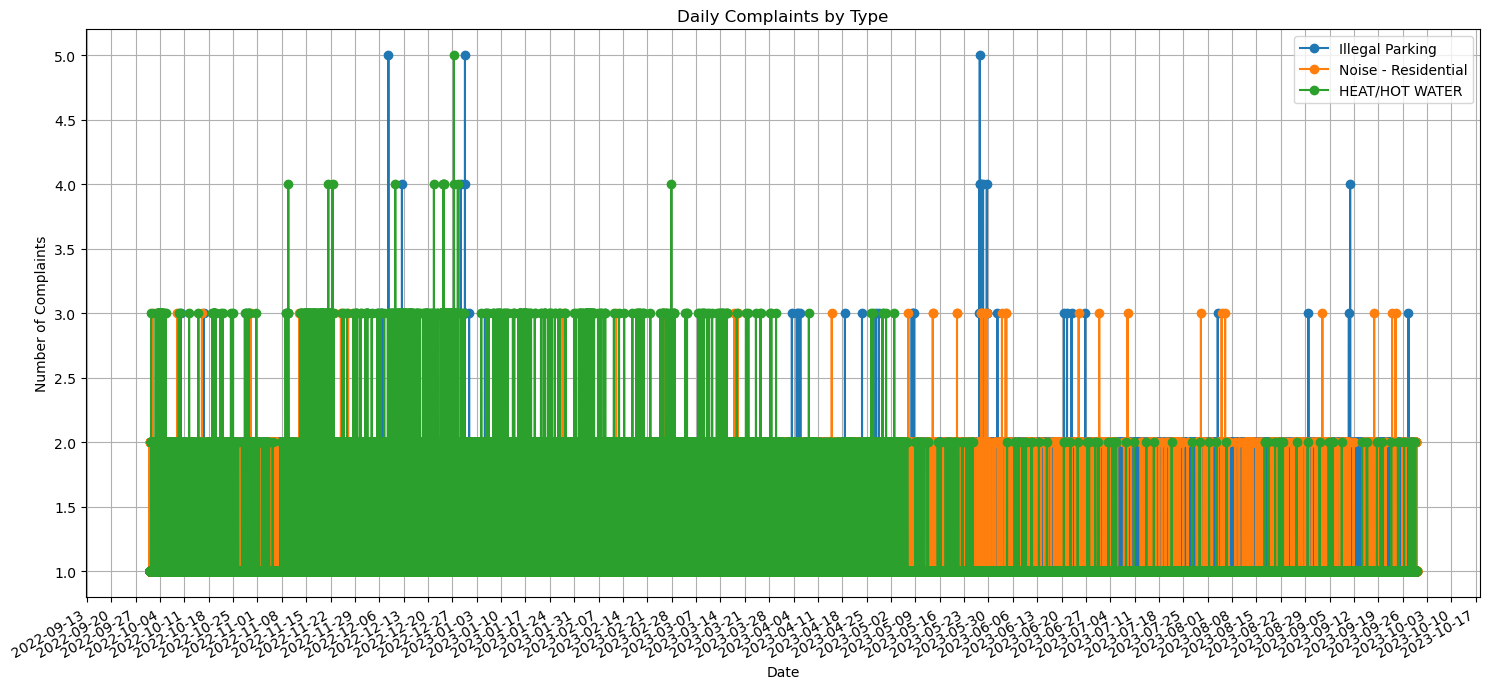

In [187]:
plot_daily_complaints_line_chart()

##### Visualization 2: What are the most common complaints in the immediate area?


- The following bar graph shows the number of complaints by type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive).

In [193]:
Visilization_2_FILENAME = QUERY_DIR / "most_common_complaints.sql"

def get_data_for_comm_complaints():
    complaints_query = """
    SELECT complaint_type, COUNT(*) AS num_complaints
    FROM three_11s
    WHERE zipcode = '10027' AND
          created_date >= '2018-10-01' AND
          created_date <= '2023-09-30'
    GROUP BY complaint_type
    ORDER BY num_complaints DESC
    LIMIT 10;
    """

    with engine.connect() as connection:
        visual_2_df = pd.read_sql(complaints_query, connection)

    write_query_to_file(complaints_query, Visilization_2_FILENAME)

    return visual_2_df

def plot_comm_complaints(dataframe):
    dataframe = get_data_for_comm_complaints()

    plt.figure(figsize=(10, 6))

    plt.bar(dataframe['complaint_type'], dataframe['num_complaints'], color='skyblue')
    plt.xticks(rotation=45, ha='right')  

    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.title('Top 10 Complaints in Zip Code 10027 (Oct 1, 2018 - Sep 30, 2023)')

    plt.tight_layout()
    plt.show()

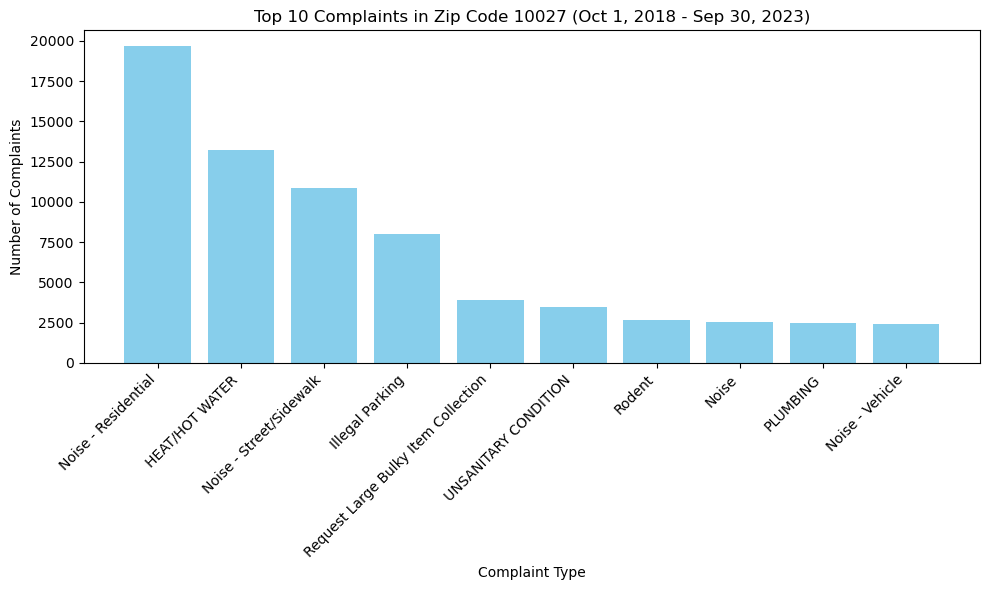

In [194]:
most_comm_complaints_df = get_data_for_comm_complaints()
plot_comm_complaints(most_comm_complaints_df)

##### Visualization 3: Is there any correlation between rent, trees, and complaints at all?


- The following two scatter plots, the first one shows the average rent compared to the number of trees by zip code between January 1st, 2015 and September 30th, 2023 (inclusive) and the other subplot shows rent compared to the number of complaints by zip code.

In [213]:
# Redefine write query to file function for append mode
def write_query_to_file_append(query, filename, mode='a'):
    with open(filename, mode) as f:
        f.write(query + "\n\n")

In [214]:
Visilization_3_FILENAME = QUERY_DIR / "correlation_rentANDtrees_complaints.sql"

def get_data_for_correlations():
    rent_query = """
    SELECT zipcode, date_2023_09_30 AS rent
    FROM zillows;
    """

    tree_query = """
    SELECT zipcode, COUNT(*) AS num_trees
    FROM trees
    GROUP BY zipcode;
    """

    complaint_query = """
    SELECT zipcode, COUNT(*) AS num_complaints
    FROM three_11s
    WHERE created_date >= '2015-01-01' AND created_date <= '2023-09-30'
    GROUP BY zipcode;
    """

    write_query_to_file_append(rent_query, Visilization_3_FILENAME)
    write_query_to_file_append(tree_query, Visilization_3_FILENAME)
    write_query_to_file_append(complaint_query, Visilization_3_FILENAME)

    with engine.connect() as connection:
        rent_df = pd.read_sql(rent_query, connection)
        tree_df = pd.read_sql(tree_query, connection)
        complaint_df = pd.read_sql(complaint_query, connection)

    # Merge dataframes on 'zipcode' with an outer join to include all zipcodes
    visual_3_df = rent_df.merge(tree_df, on='zipcode', how='outer').merge(complaint_df, on='zipcode', how='outer')

    return visual_3_df

In [215]:
def plot_correlation():
    dataframe = get_data_for_correlations()

    # Create subplots with shared x-axis (rent)
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Scatter plot for number of trees vs rent
    axs[0].scatter(dataframe['rent'], dataframe['num_trees'], color='green', alpha=0.5)
    axs[0].set_title('Number of Trees vs Rent by Zipcode')
    axs[0].set_ylabel('Number of Trees')

    # Scatter plot for number of complaints vs rent
    axs[1].scatter(dataframe['rent'], dataframe['num_complaints'], color='blue', alpha=0.5)
    axs[1].set_title('Number of Complaints vs Rent by Zipcode')
    axs[1].set_xlabel('Rent')
    axs[1].set_ylabel('Number of Complaints')

    plt.tight_layout()
    plt.show()


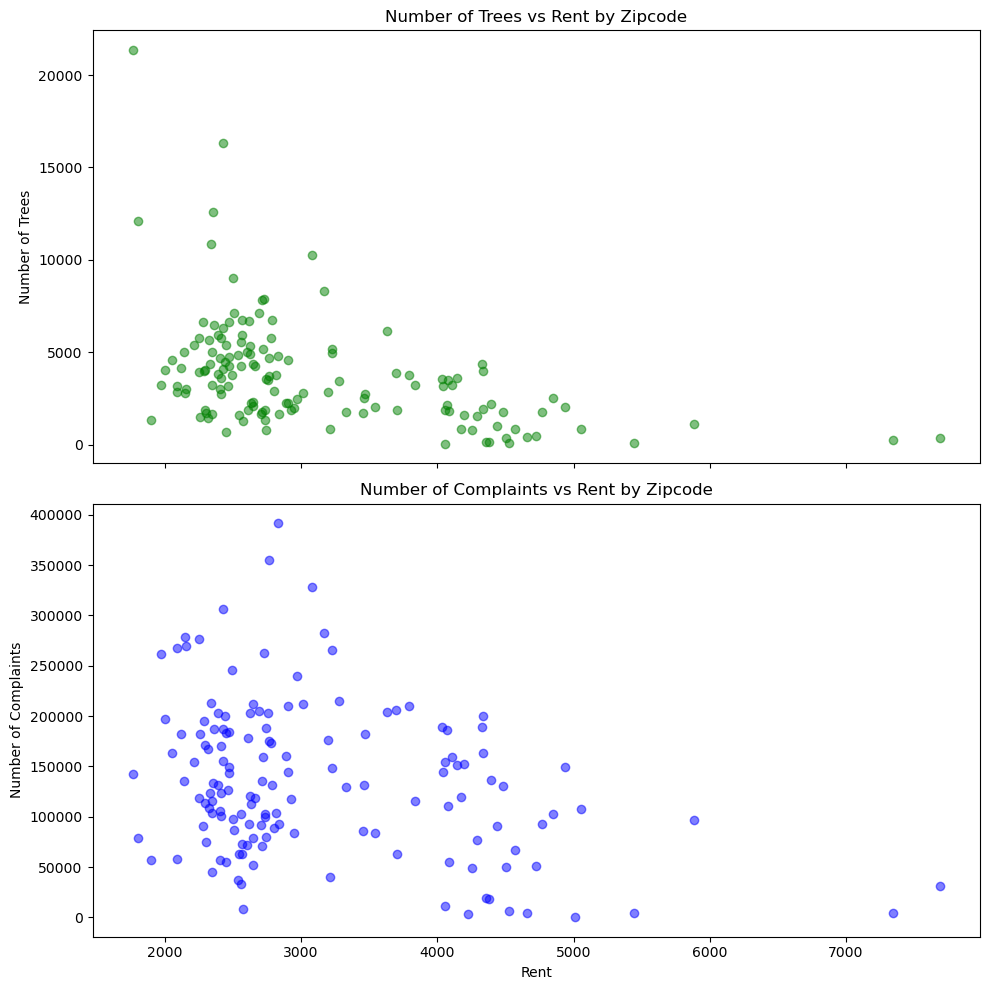

In [216]:
plot_correlation()


##### Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?


- The following boxplot shows the relation between average rent in September 2023 and the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).


In [217]:
Visilization_4_FILENAME = QUERY_DIR / "boxplot_rent_complaints.sql"

def get_boxplot_rent_complaints_data():
    rent_query = """
    SELECT zipcode, date_2023_09_30 AS rent
    FROM zillows;
    """

    complaint_query = """
    SELECT zipcode, COUNT(*) AS num_complaints
    FROM three_11s
    WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
    GROUP BY zipcode;
    """

    with engine.connect() as connection:
        rent_df = pd.read_sql(rent_query, connection)
        complaint_df = pd.read_sql(complaint_query, connection)

    write_query_to_file_append(rent_query, Visilization_4_FILENAME)
    write_query_to_file_append(complaint_query, Visilization_4_FILENAME)

    merged_df = pd.merge(rent_df, complaint_df, on='zipcode')

    merged_df['rent_bin'] = pd.cut(merged_df['rent'], bins=range(0, int(merged_df['rent'].max()) + 1000, 1000), right=False)

    grouped_data = merged_df.groupby('rent_bin')['num_complaints'].apply(list)
    boxplot_data = [grouped_data[bin] for bin in grouped_data.index]

    return boxplot_data, grouped_data.index

In [218]:
def plot_boxplot_rent_complaints(dataframe):
    boxplot_data, rent_bins = get_boxplot_rent_complaints_data()

    plt.figure(figsize=(12, 8))

    plt.boxplot(boxplot_data, labels=[str(bin) for bin in rent_bins])

    plt.title('Number of 311 Complaints vs. Rent')
    plt.xlabel('Rent')
    plt.ylabel('Number of 311 Complaints')

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

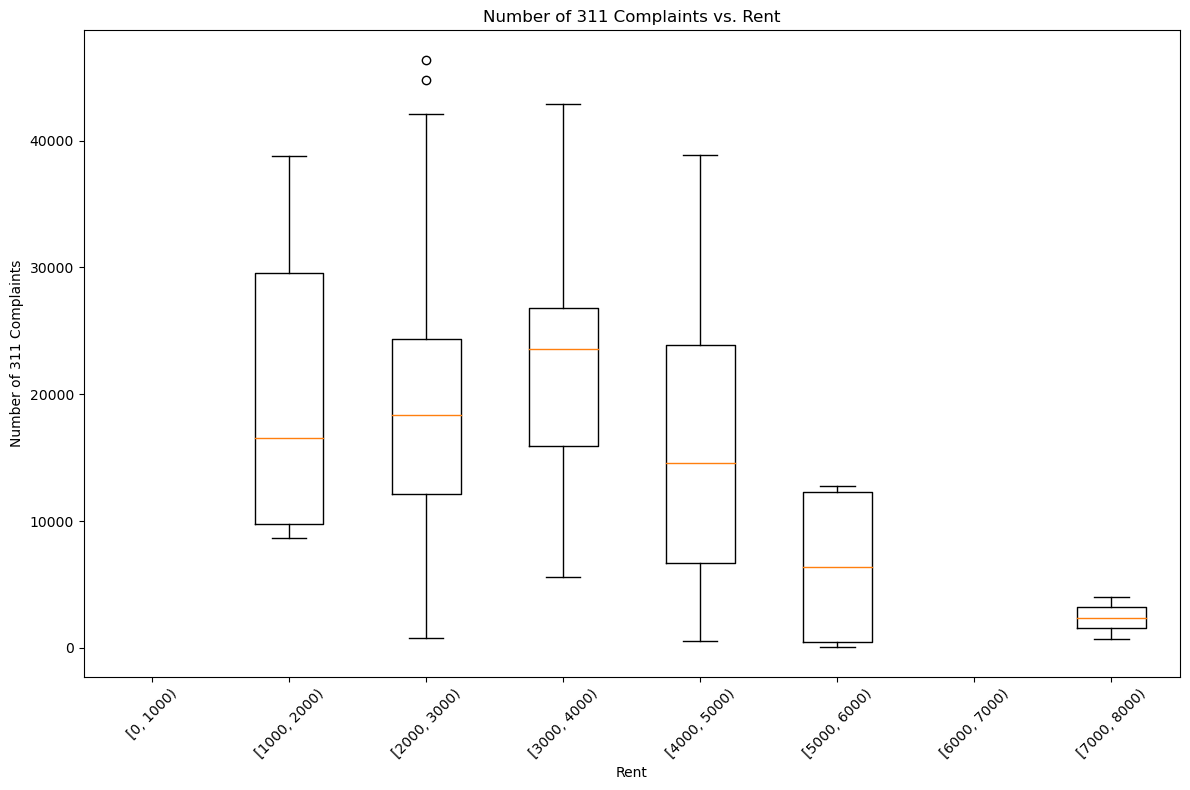

In [219]:
boxplot_rent_df = get_boxplot_rent_complaints_data()
plot_boxplot_rent_complaints(boxplot_rent_df)

##### Visualization 5: Where were the recent 311 incidents reported from in the immediate area?


- The geospatial plot shows the coordinates of reported 311 incidents that happened between January 1st, 2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of the same coordinate from Latitude: 40.80737875669467, Longitude: -73.96253174434912.


In [222]:
Visilization_5_FILENAME = QUERY_DIR / "geospatial_complaints_within_area.sql"

def get_311_incidents_data():
    longitude = -73.96253174434912  
    latitude = 40.80737875669467  
    point = f'POINT({longitude} {latitude})'

    query_311 = f"""
    SELECT latitude, longitude
    FROM three_11s
    WHERE created_date >= '2023-01-01' AND created_date <= '2023-09-30'
    AND ST_DWithin(geometry::geography, ST_GeogFromText('{point}'), 1000);
    """

    write_query_to_file(query_311, Visilization_5_FILENAME)

    with engine.connect() as connection:
        incidents_df = pd.read_sql(query_311, connection)

    incidents_df['geometry'] = incidents_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    geo_incidents_df = gpd.GeoDataFrame(incidents_df, geometry='geometry')

    return geo_incidents_df

In [223]:
def plot_311_incidents(dataframe):
    fig, ax = plt.subplots(figsize=(10, 10))

    dataframe.plot(ax=ax, marker='o', color='red', markersize=5)

    ax.set_title('311 Incidents within 1 km Radius (Jan 1, 2023 - Sep 30, 2023)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

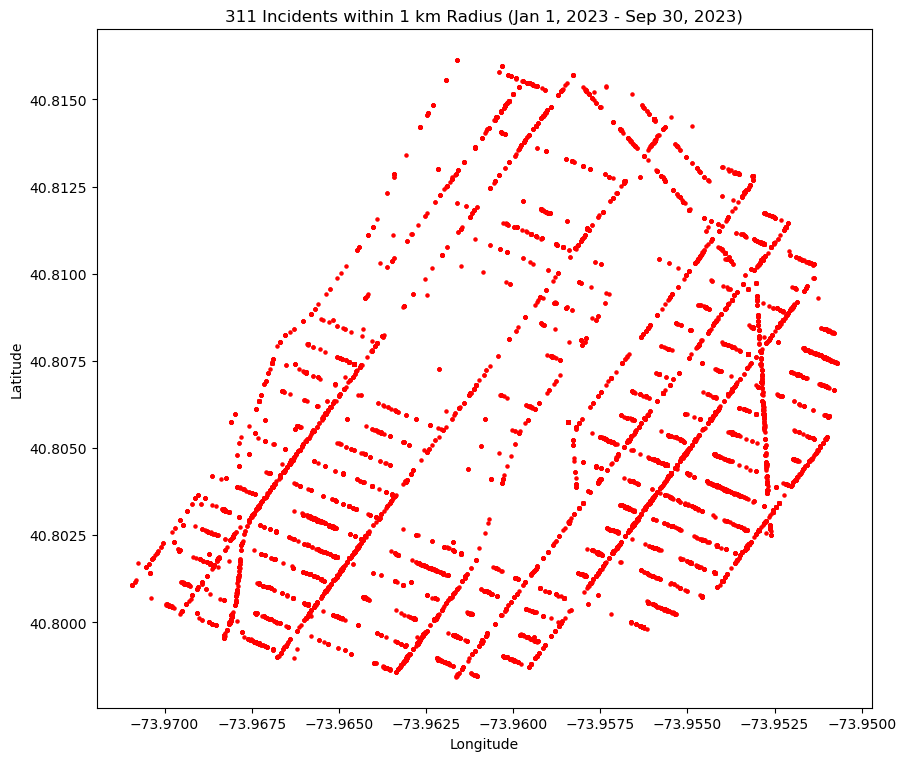

In [224]:
geo_incidents_df = get_311_incidents_data()
plot_311_incidents(geo_incidents_df)

##### Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?

- The geospatial plot shows the coordinates of trees in NYC, and the coordinates of "New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 (inclusive). 


In [239]:
Visilization_6_FILENAME = QUERY_DIR / "geospatial_tree_request_trees.sql"

def get_tree_improvement_data():
    tree_query = """
    SELECT latitude, longitude
    FROM trees;
    """

    with engine.connect() as connection:
        trees_df = pd.read_sql(tree_query, connection)

    trees_df['geometry'] = trees_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    geo_trees_df = gpd.GeoDataFrame(trees_df, geometry='geometry')


    complaint_query = """
    SELECT latitude, longitude
    FROM three_11s
    WHERE created_date BETWEEN '2018-10-01' AND '2023-09-30'
    AND complaint_type = 'New Tree Request';
    """

    with engine.connect() as connection:
        complaints_df = pd.read_sql(complaint_query, connection)

    complaints_df['geometry'] = complaints_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    geo_complaints_df = gpd.GeoDataFrame(complaints_df, geometry='geometry')

    write_query_to_file_append(tree_query, Visilization_6_FILENAME)
    write_query_to_file_append(complaint_query, Visilization_6_FILENAME)

    return geo_complaints_df, geo_trees_df

In [244]:
def plot_tree_complaints(geo_trees_df, geo_complaints_df, alpha_value=0.3):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    geo_trees_df.plot(ax=ax, color='green', markersize=10, label='Trees')
    
    geo_complaints_df.plot(ax=ax, color='red', alpha=alpha_value, label='New Tree Requests')
    
    plt.title('NYC Trees and "New Tree Request" 311 Complaints (Oct 1, 2018 - Sep 30, 2023)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.legend()
    
    plt.show()

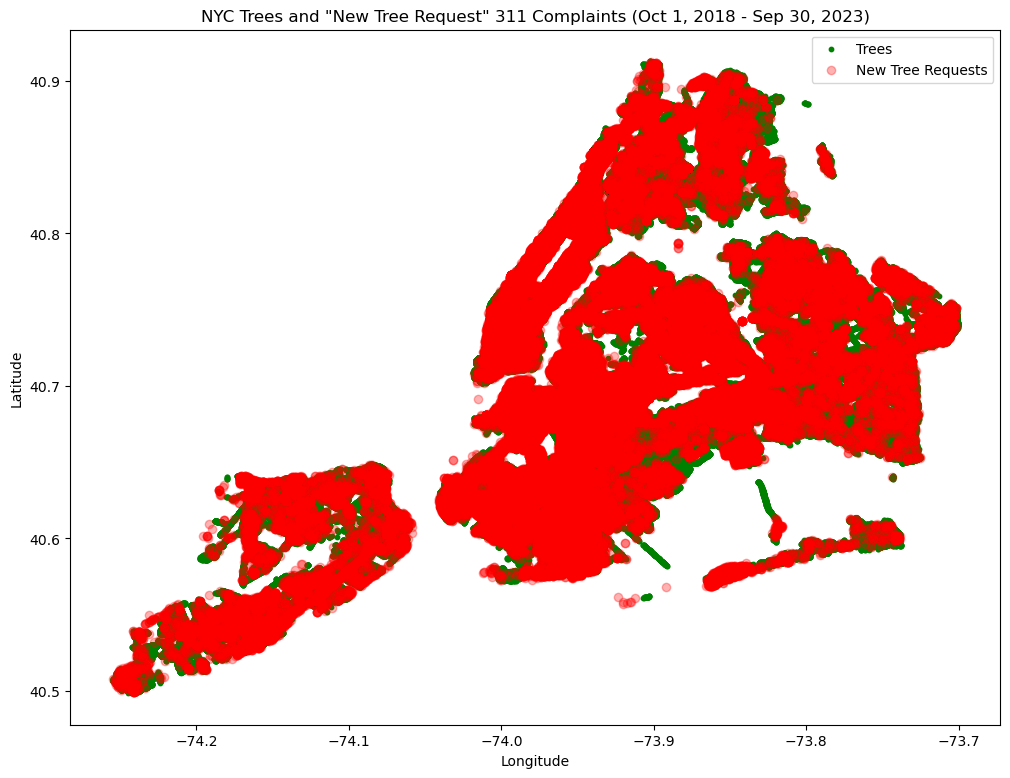

In [245]:
geo_complaints_df, geo_trees_df = get_tree_improvement_data()
plot_tree_complaints(geo_trees_df, geo_complaints_df)